In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import StackingRegressor
from mlxtend.regressor import StackingCVRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [2]:
def create_submission(pred_A, pred_B, pred_C, output_file="submission.csv"):
    """
    Create a Kaggle submission file.

    Parameters:
    - pred_A, pred_B, pred_C: Arrays containing predictions.
    - output_file: Name of the output CSV file.

    Returns:
    - None. Writes the submission to a CSV file.
    """
    
    # Concatenate predictions
    predictions = np.concatenate([pred_A, pred_B, pred_C])

    # Create an id array
    ids = np.arange(0, len(predictions))

    # Create a DataFrame
    df = pd.DataFrame({
        'id': ids,
        'prediction': predictions
    })

    # Save to CSV
    df.to_csv(output_file, index=False)
    print(f"Submission saved to {output_file}")

In [3]:
# Read in the data
data_path = '../../preprocessing/data'


columns =  ['pv_measurement', 'direct_rad:W', 'effective_cloud_cover:p', 't_1000hPa:K',
            'total_cloud_cover:p', 'air_density_2m:kgm3', 'clear_sky_rad:W',
            'visibility:m', 'relative_humidity_1000hPa:p', 'wind_speed_u_10m:ms',
            'diffuse_rad_1h:J', 'wind_speed_v_10m:ms', 'sun_azimuth:d',
            'total_radiation', 'wind_vector_magnitude', 'average_wind_speed',
            'date_forecast_fft_amplitude', 'date_forecast_fft_phase',
            'sun_elevation:d_fft_phase', 'dew_point_2m:K_rate_of_change_of_change',
            't_1000hPa:K_rate_of_change', 'clear_sky_rad:W_rate_of_change',
            'clear_sky_rad:W_rate_of_change_of_change',
            'diffuse_rad:W_rate_of_change', 'direct_rad:W_rate_of_change',
            'effective_cloud_cover:p_rate_of_change_of_change']

# For A
obs_A = pd.read_parquet(f'{data_path}/obs_A.parquet')
est_A = pd.read_parquet(f'{data_path}/est_A.parquet')
A = pd.concat([obs_A, est_A])[columns]

# For B
obs_B = pd.read_parquet(f'{data_path}/obs_B.parquet')
est_B = pd.read_parquet(f'{data_path}/est_B.parquet')
B = pd.concat([obs_B, est_B])[columns]

# For C
obs_C = pd.read_parquet(f'{data_path}/obs_C.parquet')
est_C = pd.read_parquet(f'{data_path}/est_C.parquet')
C = pd.concat([obs_C, est_C])[columns]


columns =  ['direct_rad:W', 'effective_cloud_cover:p', 't_1000hPa:K',
            'total_cloud_cover:p', 'air_density_2m:kgm3', 'clear_sky_rad:W',
            'visibility:m', 'relative_humidity_1000hPa:p', 'wind_speed_u_10m:ms',
            'diffuse_rad_1h:J', 'wind_speed_v_10m:ms', 'sun_azimuth:d',
            'total_radiation', 'wind_vector_magnitude', 'average_wind_speed',
            'date_forecast_fft_amplitude', 'date_forecast_fft_phase',
            'sun_elevation:d_fft_phase', 'dew_point_2m:K_rate_of_change_of_change',
            't_1000hPa:K_rate_of_change', 'clear_sky_rad:W_rate_of_change',
            'clear_sky_rad:W_rate_of_change_of_change',
            'diffuse_rad:W_rate_of_change', 'direct_rad:W_rate_of_change',
            'effective_cloud_cover:p_rate_of_change_of_change']

# For testing

test_A = pd.read_parquet(f'{data_path}/test_A.parquet')[columns].dropna()
test_B = pd.read_parquet(f'{data_path}/test_B.parquet')[columns].dropna()
test_C = pd.read_parquet(f'{data_path}/test_C.parquet')[columns].dropna()


print(A.columns)


Index(['pv_measurement', 'direct_rad:W', 'effective_cloud_cover:p',
       't_1000hPa:K', 'total_cloud_cover:p', 'air_density_2m:kgm3',
       'clear_sky_rad:W', 'visibility:m', 'relative_humidity_1000hPa:p',
       'wind_speed_u_10m:ms', 'diffuse_rad_1h:J', 'wind_speed_v_10m:ms',
       'sun_azimuth:d', 'total_radiation', 'wind_vector_magnitude',
       'average_wind_speed', 'date_forecast_fft_amplitude',
       'date_forecast_fft_phase', 'sun_elevation:d_fft_phase',
       'dew_point_2m:K_rate_of_change_of_change', 't_1000hPa:K_rate_of_change',
       'clear_sky_rad:W_rate_of_change',
       'clear_sky_rad:W_rate_of_change_of_change',
       'diffuse_rad:W_rate_of_change', 'direct_rad:W_rate_of_change',
       'effective_cloud_cover:p_rate_of_change_of_change'],
      dtype='object')


In [4]:
X_A = A.drop(columns=['pv_measurement'])
y_A = A['pv_measurement']

X_B = B.drop(columns=['pv_measurement'])
y_B = B['pv_measurement']

X_C = C.drop(columns=['pv_measurement'])
y_C = C['pv_measurement']


In [5]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error

# Assuming X_A and y_A are defined somewhere in your code
# Split the dataset into training and testing sets without shuffling
X_train_A, X_test_A, y_train_A, y_test_A = train_test_split(X_A, y_A, test_size=0.2, shuffle=False)

# Define a parameter grid to search over
param_grid = {
    'n_estimators': [150, 300, 450],  # Three alternatives close to the best n_estimators
    'learning_rate': [0.006, 0.012, 0.018],  # Three alternatives around the best learning rate
    'max_depth': [3, 7, 12],  # Including values just below and above the best max depth
    'subsample': [0.912],  # Three alternatives around the best subsample
    'colsample_bytree': [0.664, 0.684],  # Three alternatives around the best colsample_bytree
    'gamma': [0.5, 3, 10],  # Three alternatives around the best gamma
    'min_child_weight': [5, 15],  # Expanding this to include values around the best
    'reg_alpha': [0.05, 2],  # Three alternatives around the best reg_alpha
    'reg_lambda': [0.5, 2]  # Three alternatives around the best reg_lambda
}


# Initialize XGBRegressor
xgb_A = XGBRegressor(random_state=0, booster='gbtree')

# Define MAE scorer
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_A,
    param_grid=param_grid,
    scoring=mae_scorer,  # Use the MAE scorer defined above
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity
    n_jobs=-1  # Number of jobs to run in parallel
)

# Perform the grid search on the training data
print('Performing grid search...')
grid_search.fit(X_train_A, y_train_A)

# Get the best parameters and best score from the grid search
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Change sign because score is negative

# Print the best parameters and best score
print(f'Best parameters: {best_params}')
print(f'Best MAE score: {best_score}')

# Fit the model with optimized parameters
xgb_A_optimized = XGBRegressor(**best_params, random_state=0, booster='gbtree').fit(X_train_A, y_train_A)

# Make predictions with the optimized model
pred_A_optimized = xgb_A_optimized.predict(X_test_A)

# Calculate and print the MAE of the optimized model
mae_optimized = mean_absolute_error(y_test_A, pred_A_optimized)
print(f'Optimized model MAE: {mae_optimized}')




Performing grid search...
Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.05, reg_lambda=0.5, subsample=0.912; total time=   2.1s
[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.05, reg_lambda=0.5, subsample=0.912; total time=   2.2s
[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.05, reg_lambda=0.5, subsample=0.912; total time=   2.3s
[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.05, reg_lambda=0.5, subsample=0.912; total time=   2.3s
[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_child_weight=5, n_estimators=150, reg_alpha=0.05, reg_lambda=2, subsample=0.912; total time=   2.3s
[CV] END colsample_bytree=0.664, gamma=0.5, learning_rate=0.006, max_depth=3, min_

In [6]:
print(f'Best parameters: {best_params}')
# Best parameters: {'colsample_bytree': 0.664, 'gamma': 3, 'learning_rate': 0.012, 'max_depth': 12, 'min_child_weight': 15, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2, 'subsample': 0.912}

Best parameters: {'colsample_bytree': 0.664, 'gamma': 3, 'learning_rate': 0.012, 'max_depth': 12, 'min_child_weight': 15, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2, 'subsample': 0.912}


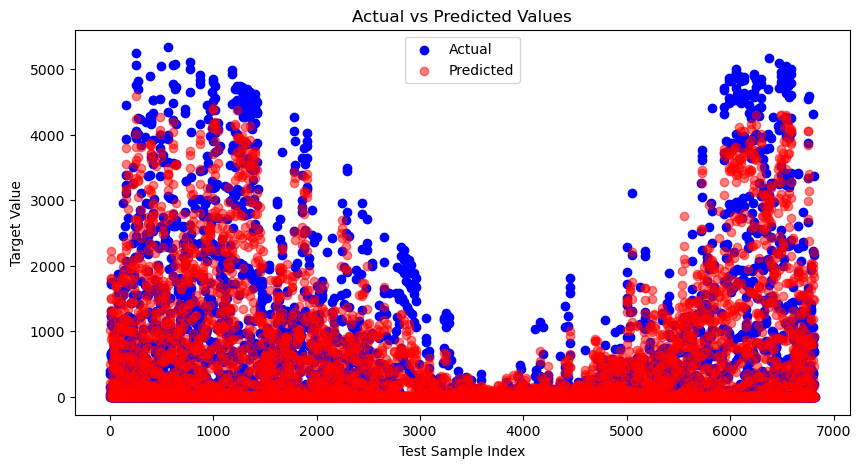

In [7]:

y_pred_A_test = xgb_A_optimized.predict(X_test_A)

# Plotting the actual vs predicted values
plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_A)), y_test_A, color='blue', label='Actual')
plt.scatter(range(len(y_pred_A_test)), y_pred_A_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()




In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Split your dataset B into training and testing sets without shuffling
X_train_B, X_test_B, y_train_B, y_test_B = train_test_split(X_B, y_B, test_size=0.2, shuffle=False)

# Define your parameter grid
param_grid = {
    'n_estimators': [490, 499, 508],  # Three alternatives close to the best n_estimators
    'learning_rate': [0.022, 0.024, 0.026],  # Three alternatives around the best learning rate
    'max_depth': [3],  # Including values just below and above the best max depth
    'subsample': [0.912],  # Three alternatives around the best subsample
    'colsample_bytree': [0.664, 0.684],  # Three alternatives around the best colsample_bytree
    'gamma': [0.458, 0.478, 0.498],  # Three alternatives around the best gamma
    'min_child_weight': [2, 3, 4],  # Expanding this to include values around the best
    'reg_alpha': [0.0799, 0.0899],  # Three alternatives around the best reg_alpha
    'reg_lambda': [1.923, 1.946]  # Three alternatives around the best reg_lambda
}


# Initialize XGBRegressor
xgb_B = XGBRegressor(random_state=0, booster='gbtree')

# Make a scorer from mean_absolute_error
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search_B = GridSearchCV(
    estimator=xgb_B,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=4,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search on the training data
print('Performing grid search...')
grid_search_B.fit(X_train_B, y_train_B)

# Get the best parameters and best score from the grid search
best_params_B = grid_search_B.best_params_
best_score_B = -grid_search_B.best_score_  # Multiply by -1 because the score is negative

# Print the best parameters and best MAE score
print(f'Best parameters: {best_params_B}')
print(f'Best MAE score: {best_score_B}')

# Use the best parameters to create a new model
xgb_B_optimized = XGBRegressor(**best_params_B, random_state=0, booster='gbtree')

# Fit the model with optimized parameters on the full training data
xgb_B_optimized.fit(X_train_B, y_train_B)

# Predict with the optimized model on the test data
pred_B_optimized = xgb_B_optimized.predict(X_test_B)

# Calculate and print the MAE for the test data
test_mae_B = mean_absolute_error(y_test_B, pred_B_optimized)
print(f'Test MAE for optimized model: {test_mae_B}')



Performing grid search...
Fitting 4 folds for each of 648 candidates, totalling 2592 fits
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  15.8s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.946, subsample=0.912; total time=  15.9s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  16.1s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  16.3s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.9

In [9]:
print(f'Best parameters: {best_params}')

Best parameters: {'colsample_bytree': 0.664, 'gamma': 3, 'learning_rate': 0.012, 'max_depth': 12, 'min_child_weight': 15, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2, 'subsample': 0.912}


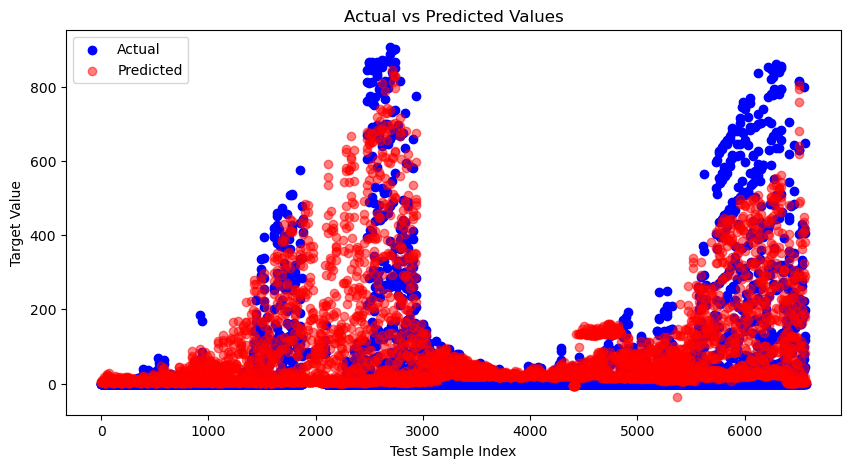

In [10]:
# Get predictions for the test set (already have y_test_B for actual values)
y_pred_B_test = xgb_B_optimized.predict(X_test_B)

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_B)), y_test_B, color='blue', label='Actual')
plt.scatter(range(len(y_pred_B_test)), y_pred_B_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()




In [11]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
from xgboost import XGBRegressor
import numpy as np

# Split your dataset B into training and testing sets without shuffling
X_train_C, X_test_C, y_train_C, y_test_C = train_test_split(X_C, y_C, test_size=0.2, shuffle=False)

# Define your parameter grid
param_grid = {
    'n_estimators': [490, 499, 508],  # Three alternatives close to the best n_estimators
    'learning_rate': [0.022, 0.024, 0.026],  # Three alternatives around the best learning rate
    'max_depth': [3],  # Including values just below and above the best max depth
    'subsample': [0.912],  # Three alternatives around the best subsample
    'colsample_bytree': [0.664, 0.684],  # Three alternatives around the best colsample_bytree
    'gamma': [0.458, 0.478, 0.498],  # Three alternatives around the best gamma
    'min_child_weight': [2, 3, 4],  # Expanding this to include values around the best
    'reg_alpha': [0.0799, 0.0899],  # Three alternatives around the best reg_alpha
    'reg_lambda': [1.923, 1.946]  # Three alternatives around the best reg_lambda
}

# Initialize XGBRegressor
xgb_C = XGBRegressor(random_state=0, booster='gbtree')

# Make a scorer from mean_absolute_error
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# Initialize GridSearchCV
grid_search_C = GridSearchCV(
    estimator=xgb_C,
    param_grid=param_grid,
    scoring=mae_scorer,
    cv=4,
    verbose=2,
    n_jobs=-1
)

# Perform the grid search on the training data
print('Performing grid search...')
grid_search_C.fit(X_train_C, y_train_C)

# Get the best parameters and best score from the grid search
best_params_C = grid_search_C.best_params_
best_score_C = -grid_search_C.best_score_  # Multiply by -1 because the score is negative

# Print the best parameters and best MAE score
print(f'Best parameters: {best_params_C}')
print(f'Best MAE score: {best_score_C}')

# Use the best parameters to create a new model
xgb_C_optimized = XGBRegressor(**best_params_C, random_state=0, booster='gbtree')

# Fit the model with optimized parameters on the full training data
xgb_C_optimized.fit(X_train_C, y_train_C)

# Predict with the optimized model on the test data
pred_C_optimized = xgb_C_optimized.predict(X_test_C)

# Calculate and print the MAE for the test data
test_mae_C = mean_absolute_error(y_test_C, pred_C_optimized)
print(f'Test MAE for optimized model: {test_mae_C}')

Performing grid search...
Fitting 4 folds for each of 648 candidates, totalling 2592 fits
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.946, subsample=0.912; total time=  11.0s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  11.1s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  11.2s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.923, subsample=0.912; total time=  11.4s
[CV] END colsample_bytree=0.664, gamma=0.458, learning_rate=0.022, max_depth=3, min_child_weight=2, n_estimators=490, reg_alpha=0.0799, reg_lambda=1.9

In [12]:
print(f'Best parameters: {best_params}')

Best parameters: {'colsample_bytree': 0.664, 'gamma': 3, 'learning_rate': 0.012, 'max_depth': 12, 'min_child_weight': 15, 'n_estimators': 300, 'reg_alpha': 2, 'reg_lambda': 2, 'subsample': 0.912}


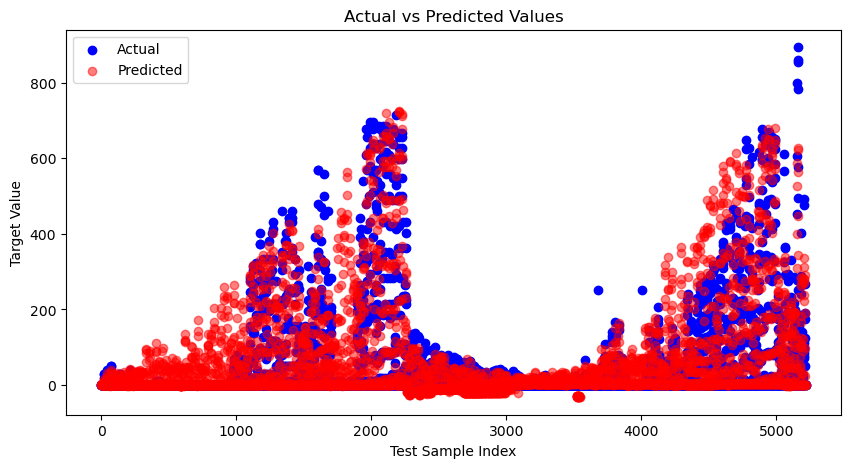

In [13]:
# Get predictions for the test set (already have y_test_B for actual values)
y_pred_C_test = xgb_C_optimized.predict(X_test_C)

plt.figure(figsize=(10,5))
plt.scatter(range(len(y_test_C)), y_test_C, color='blue', label='Actual')
plt.scatter(range(len(y_pred_C_test)), y_pred_C_test, color='red', label='Predicted', alpha=0.5)
plt.title('Actual vs Predicted Values')
plt.xlabel('Test Sample Index')
plt.ylabel('Target Value')
plt.legend()
plt.show()


In [14]:
create_submission(pred_A, pred_B, pred_C, output_file="../../submission.csv")

NameError: name 'pred_A' is not defined